In [28]:
import numpy as np
import matplotlib.pyplot as plt

In [29]:
# load data
memory_capacity = np.load("data/mccoef_mc_tanh.npy") # shape = [points, trial, max_leadout]
coef = np.load("data/mccoef_coef_tanh.npy") # shape = [points, trial]
params = np.load("data/mccoef_params_tanh.npy") # shape = [points, 3(g, sigma_s, sigma_n)]

N = 10000
points = memory_capacity.shape[0]
trial = memory_capacity.shape[1]
max_leadout = memory_capacity.shape[2]


In [30]:
# calculating Lhalf

Lhalf_list = np.zeros([points, trial])

for num in range(points):
    mcs = memory_capacity[num]
    meancoef = np.mean(coef[num])
    mc1 = np.mean(mcs[:,0]) #trial average
    div = mc1*np.ones([trial,1])@(np.arange(1,max_leadout+1).reshape(1,-1))
    ratios = mcs/div 
    
    #calc Lhalf
    for i in range(trial):
        for j in range(1,max_leadout):
            if ratios[i,j] < 0.5:
                break
        Lhalf_list[num, i] = j+1

In [31]:
Lhalf_mean = np.mean(Lhalf_list, axis=1)
Lhalf_std = np.std(Lhalf_list, axis=1)
coef_mean = np.mean(coef, axis=1)
coef_std = np.std(coef, axis=1)

In [32]:
# judge whether numerically obtained Lhalf is within the theoretical scaling regime

judge_list = np.zeros(points)

for i in range(points):
    g, sigma_s, sigma_n = params[i,:]
    lhalf = Lhalf_mean[i]

    sigma_s_tilde = sigma_s*(N**0.25)
    K = 0.1
    for _ in range(1000):
        K = sigma_n**2 + sigma_s**2 + g**2 * (-1 + (4/np.pi)*np.arctan(np.sqrt(1+np.pi*K))) 
    
    alpha = np.arange(0.0, 1.01, 0.01)
    A = alpha*(sigma_s_tilde**2)/K
    B = g**2 / (1+0.5*np.pi*K)
    
    mc_theory = np.zeros(len(alpha))
    for m in range(1,100):
        mc_theory += (-1)**(m-1) * (A**m) / (1-B**m)
        
    denominator = alpha[1:]*(sigma_s_tilde**2/K)/(1-B)
    r = mc_theory[1:]/(denominator+ 1e-7)
    diverged_alpha = alpha[np.sum(np.where(r[1:]-r[:-1]<0, 1, 0))+1]
    diverged_L = diverged_alpha*np.sqrt(N)
    
    # if Lhalf < diverged_L, then the plot is assumed to be within theory (denoted by "1")
    judge_list[i] = 1*(lhalf < diverged_L) 


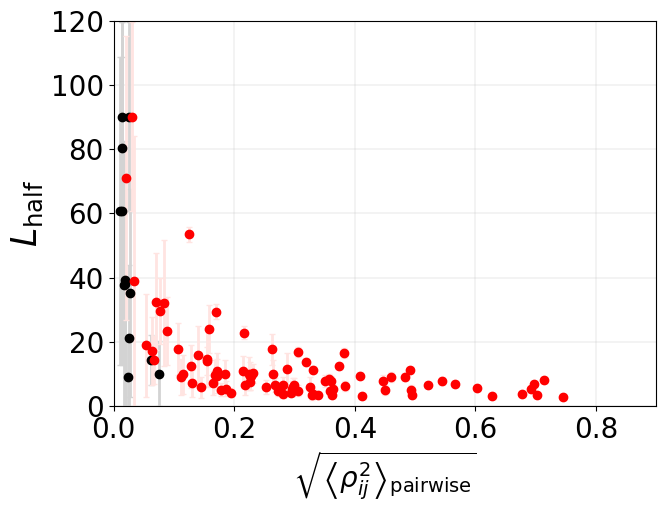

In [45]:
fig = plt.figure(figsize=(7,5))
plt.errorbar(coef_mean[judge_list==1], Lhalf_mean[judge_list==1], xerr=coef_std[judge_list==1], yerr=Lhalf_std[judge_list==1], fmt="o", capsize=2, color="k", elinewidth=2, ecolor="lightgray") # a plot is black when it is within theory
plt.errorbar(coef_mean[judge_list==0], Lhalf_mean[judge_list==0], xerr=coef_std[judge_list==0], yerr=Lhalf_std[judge_list==0], fmt="o", capsize=2, color="r", elinewidth=2, ecolor="mistyrose") # a plot is red when it is beyond theory
plt.xlabel(r"$\sqrt{ \left\langle \rho_{ij}^2 \right\rangle_{\rm pairwise} }$", size=20)
plt.ylabel(r"$L_{\rm{half}}$",fontsize=25)
plt.tick_params(labelsize=20) 
plt.grid(linewidth=0.2)
plt.ylim(0,120)
plt.xlim(0,0.9)
plt.show()

In [34]:
# Statistical test for Pearson's r between log(√<rho^2>) and log(Lhalf)

from scipy.stats import pearsonr

X = np.log(coef_mean)
Y = np.log(Lhalf_mean)

correlation, p_value = pearsonr(X, Y)

print(f"Pearson's r ={ correlation } (p value={p_value})")

Pearson's r =-0.8103322995982911 (p value=1.762566837459609e-24)
